# Máquinas de Boltzmann

Las máquinas de Boltzmann son un tipo de redes neuronales recurrentes estocásticas que se derivan de los modelos de Procesamiento Distribuido Paralelo (PDP). Estos se caracterizan por tener unidades altamente interconectadas y usualmente se utilizan en tareas como la visión artificial, la percepción y cualquier otro problema de ese estilo que usualmente requiere bastante poder de cómputo. 

Las **Máquinas de Boltzman** se originaron cuando se hizo disponible la tecnología necesaria para soportarlos a finales de los años 80's. 

Están inspiradas en la **Distribución de Boltzman** la cual establece que el estado actual del sistema depende de la energía y la termperatura del mismo. La energía de una máquiana de boltzman es equivalente a la desviación, entre más energía tenga el sistema tendrás más desviación. Teniendo en cuenta esto, el objetivo es entrenar la máquina hasta su punto de mínima energía. 

Como también se da el problema de la búsqueda del mínimo global, en donde el modelo puede estancarse en un mínimo global, en ocaciones se permite al modelo hacer saltos periodicos de un estado de mayor energí a uno de menor energía para encontrar la solución más óptima.


<h2> Aplicaciones:</h2>

* Sistemas de recomendación 
* Reduccion de dimensionalidades



En la imagen las 3 unidades en azul son neuronas ocultas, y el resto son visibles. Las neuronas visibles pueden recibir los datos de entrada, y son los nodos que retornan 

<center>

![Las 3 unidades en azul son neuronas ocultas, y el resto son visibles.](https://wikiimg.tojsiabtv.com/wikipedia/commons/thumb/7/7a/Boltzmannexamplev1.png/220px-Boltzmannexamplev1.png)

</center>


### Sigmoid

$\rho(x) = \frac{1}{1 + e^{-x}}$

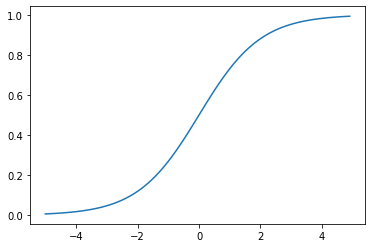

In [ ]:
from matplotlib import pyplot
import numpy as np

x = [(i - 50)/10 for i in range(100)]
y = [1/(1 + np.exp(-x_val)) for x_val in x]

pyplot.plot(x, y)

# Implementation

Based on the explanation here: 
- https://www.cs.toronto.edu/~hinton/csc321/readings/boltz321.pdf 
- https://rubikscode.net/2018/10/01/introduction-to-restricted-boltzmann-machines/
- https://rubikscode.net/2018/10/22/implementing-restricted-boltzmann-machine-with-python-and-tensorflow/
- http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
- https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine
- https://es.khanacademy.org/science/ap-chemistry-beta/x2eef969c74e0d802:intermolecular-forces-and-properties/x2eef969c74e0d802:kinetic-molecular-theory/v/maxwell-boltzmann-distribution
- https://github.com/farhanchoudhary/Deep-Learning-A-Z-Hands-on-Artificial-Neural-Network.git

## Restricted Boltzman Machine

A general boltzamn machine wasn't implemented due to it's computational complexity

In [1]:
import numpy as np
import random as rand
import json

def sigmoid(x):
  if x < -20: return 0
  if x > 20: return 1

  return 1/(1 + np.exp(-x))

# Node class
class BoltzmanMachineNode:
  
  def __init__(self, bm, idx, is_visible, bias=0, initial_state=0):
    self.bm = bm # Link to the boltzman machine
    self.idx = idx
    self.bias = bias
    self.state = initial_state
    self.is_visible = is_visible

  def prob_activation(self):
    if self.is_visible:
      return sigmoid(self.bias + sum([self.bm.w[self.idx][j] for j in range(self.bm.total_h_nodes)]))
    else:
      return sigmoid(self.bias + sum([self.bm.w[i][self.idx] for i in range(self.bm.total_v_nodes)]))

  def eval_update(self):
    if rand.random() < self.prob_activation():
      return 1
    else:
      return 0

# Boltzman Machine class
class BoltzmanMachine:
  def __init__(self, visible_nodes, hidden_nodes, learning_rate=0.2):
    self.total_v_nodes = visible_nodes
    self.total_h_nodes = hidden_nodes
    self.total_nodes = visible_nodes + hidden_nodes
    self.learning_rate = learning_rate

    # Initialize visible and hidden nodes
    self.v_nodes = np.array([
      BoltzmanMachineNode(self, idx, True, bias=0) for idx in range(visible_nodes)
    ])

    self.h_nodes = np.array([
      BoltzmanMachineNode(self, idx, False, bias=0) for idx in range(hidden_nodes)
    ])
    
    # Initialize the weights
    self.w = np.zeros((visible_nodes, hidden_nodes), float)
    for i in range(visible_nodes):
      for j in range(hidden_nodes):
        self.w[i][j] = rand.random()


  ### AUXILIAR FUNCTIONS

  # returns a binary vector with the state of the visible nodes 
  def v_vector(self):
    return np.array([node.state for node in self.v_nodes])

  # returns a binary vector with the state of the hidden nodes 
  def h_vector(self):
    return np.array([node.state for node in self.h_nodes])

  def v_bias(self):
    return np.array([node.bias for node in self.v_nodes])

  def h_bias(self):
    return np.array([node.bias for node in self.h_nodes])

  def new_v_state(self):
    return np.array([v_node.eval_update() for v_node in self.v_nodes])

  def new_h_state(self):
    return np.array([h_node.eval_update() for h_node in self.h_nodes])

  def set_visible(self, new_v_vector):
    for i in range(len(new_v_vector)):
      self.v_nodes[i].state = new_v_vector[i]

  def set_hidden(self, new_h_vector):
    for i in range(len(new_h_vector)):
      self.h_nodes[i].state = new_h_vector[i]

  def reset_state(self):
    for v_node in self.v_nodes: v_node.state = 0
    for h_node in self.h_nodes: h_node.state = 0

  def random_state(self):
    for v_node in self.v_nodes: v_node.state = 0 if rand.random() < 0.5 else 1
    for h_node in self.h_nodes: h_node.state = 0 if rand.random() < 0.5 else 1

  ### IMPORTANT FUNCTIONS

  # Updates the state of the visible noodes
  def update_v(self):
    self.set_visible(self.new_v_state())

  # Updates the state of the hidden noodes
  def update_h(self):
    self.set_hidden(self.new_h_state())

  # Implements the contrastive divergence algorithm
  def train(self, input, cd=1):
    
    v = input
    self.set_visible(input)

    self.update_h()
    h = self.h_vector()

    for _ in range(cd):
      self.update_v()
      self.update_h()
      
    vp = self.v_vector()
    hp = self.h_vector()

    # Update weights
    for i in range(self.total_v_nodes):
      for j in range(self.total_h_nodes):
        self.w[i][j] += self.learning_rate*(v[i]*h[j]- vp[i]*hp[j])

    # Update biases
    for i in range(self.total_v_nodes):
      self.v_nodes[i].bias += self.learning_rate * (v[i] - vp[i])

    for i in range(self.total_h_nodes):
      self.h_nodes[i].bias += self.learning_rate * (h[i] - hp[i])

  ### UTIL FUNCTIONS

  def state_energy(self, v_vector, h_vector):
    s1 = sum([v_node.bias * v_vector[v_node.idx] for v_node in self.v_nodes])
    s2 = sum([h_node.bias * h_vector[h_node.idx] for h_node in self.h_nodes])
    s3 = sum([sum([v_vector[v_node.idx] * h_vector[h_node.idx] * self.w[v_node.idx][h_node.idx] for h_node in self.h_nodes]) for v_node in self.v_nodes])
    return -s1 - s2 - s3

  def vector_exp_energy(self, v_vector):
    binary_format = '0' + str(self.total_h_nodes) + 'b'
    vector_sum = 0 
    for i in range(2**self.total_h_nodes):
      h_vector = [0 if c == '0' else 1 for c in format(i, binary_format)]
      vector_sum += np.exp(-self.state_energy(v_vector, h_vector))

    return vector_sum
  
  def export_to_file(self, name):

    with open('a' + str(name) + '.json', 'w') as f: json.dump(self.v_bias().tolist(), f)
    with open('b' + str(name) + '.json', 'w') as f: json.dump(self.h_bias().tolist(), f)
    with open('w' + str(name) + '.json', 'w') as f: json.dump(self.w.tolist(), f)

  def import_from_file(self, name):

    with open('a' + str(name) + '.json', 'r') as f: self.w = json.load(f)
    with open('b' + str(name) + '.json', 'r') as f: bias_v = json.load(f)
    with open('w' + str(name) + '.json', 'r') as f: bias_h = json.load(f)

    for i in range(self.total_v_nodes): self.v_nodes[i].bias = bias_v[i]
    for i in range(self.total_h_nodes): self.h_nodes[i].bias = bias_h[i]

  def import_from_obj(self, obj):
    self.w = json.loads(obj['values']['w'])
    bias_v = json.loads(obj['values']['a'])
    bias_h = json.loads(obj['values']['b'])

    for i in range(self.total_v_nodes): self.v_nodes[i].bias = bias_v[i]
    for i in range(self.total_h_nodes): self.h_nodes[i].bias = bias_h[i]
    

## Simple example

Ejemplo simple con una entrada de 2 bits

Se ebtrebara para que aumente la probabilidad de que produzca el vector `[1, 0]`

In [7]:
bm = BoltzmanMachine(2, 2, learning_rate=0.01)

train_vector = [1, 0]

for i in range(1000):
  bm.train(np.array(train_vector), 10) # Tran the bm with CD-10

for _ in range(10): # Print 10 examples generated with the bm
  bm.reset_state()
  bm.update_h()
  bm.update_v()

  print(bm.v_vector())


[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[1 0]
[0 0]
[1 0]
[1 0]


## Mnist dataset

Whe are going to train the BM with the MNIST dataset. More information [here](http://yann.lecun.com/exdb/mnist/)

In [2]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

print()

def img2binvec(img):
  binvec = np.zeros((28*28), int)
  for y in range(28):
    for x in range(28):
      binvec[28*y + x] = 0 if img[y][x] < 64 else 1

  return binvec

def binvec2img(binvec):
  img = np.zeros((28, 28), int)
  for y in range(28):
    for x in range(28):
      img[y][x] = binvec[28*y + x] 

  return img



2022-09-30 23:24:23.169919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-30 23:24:23.405646: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-30 23:24:23.405678: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-30 23:24:23.442283: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-30 23:24:24.571660: W tensorflow/stream_executor/platform/de

## Train the BM 


### Train for each digit

Train a boltzman machne to predict each digit. (**WARNING: Needs a lot of time**, you can use our pretrained data)

In [3]:
# For each digit
for i in range(0, 10):
  print("\n#########", i, "############")
  bm_minst = BoltzmanMachine(28*28, 500, learning_rate=0.01)
  character_ds = train_X[train_y == i]

  total = len(character_ds)
  current = 0
  last_p = 0
  for traim_img in character_ds:
    
    if current/total >= last_p:
      last_p += 0.01
      print(current*100//total, '%', end='; ')
    
    current += 1

    bm_minst.train(np.array(img2binvec(traim_img)), 1)

  # Save the data
  bm_minst.export_to_file(i)


######### 6 ############
0 %; 1 %; 2 %; 3 %; 4 %; 5 %; 6 %; 7 %; 8 %; 9 %; 10 %; 11 %; 12 %; 13 %; 14 %; 15 %; 16 %; 17 %; 18 %; 19 %; 20 %; 21 %; 22 %; 23 %; 24 %; 25 %; 26 %; 27 %; 28 %; 29 %; 30 %; 31 %; 32 %; 33 %; 34 %; 35 %; 36 %; 37 %; 38 %; 39 %; 40 %; 41 %; 42 %; 43 %; 44 %; 45 %; 46 %; 47 %; 48 %; 49 %; 50 %; 51 %; 52 %; 53 %; 54 %; 55 %; 56 %; 57 %; 58 %; 59 %; 60 %; 61 %; 62 %; 63 %; 64 %; 65 %; 66 %; 67 %; 68 %; 69 %; 70 %; 71 %; 72 %; 73 %; 74 %; 75 %; 76 %; 77 %; 78 %; 79 %; 80 %; 81 %; 82 %; 83 %; 84 %; 85 %; 86 %; 87 %; 88 %; 89 %; 90 %; 91 %; 92 %; 93 %; 94 %; 95 %; 96 %; 97 %; 98 %; 99 %; 
######### 7 ############
0 %; 1 %; 2 %; 3 %; 4 %; 5 %; 6 %; 7 %; 8 %; 9 %; 10 %; 11 %; 12 %; 13 %; 14 %; 15 %; 16 %; 17 %; 18 %; 19 %; 20 %; 21 %; 22 %; 23 %; 24 %; 25 %; 26 %; 27 %; 28 %; 29 %; 30 %; 31 %; 32 %; 33 %; 34 %; 35 %; 36 %; 37 %; 38 %; 39 %; 40 %; 41 %; 42 %; 43 %; 44 %; 45 %; 46 %; 47 %; 48 %; 49 %; 50 %; 51 %; 52 %; 53 %; 54 %; 55 %; 56 %; 57 %; 58 %; 59 %; 60 %; 61

# Train for all digits

Tran the BM ot recognize all the digits

In [ ]:
bm_minst = BoltzmanMachine(28*28, 500, learning_rate=0.01)

total = len(train_X)
current = 0
last_p = 0
for traim_img in train_X:
    if current/total >= last_p:
        last_p += 0.01
        print(current/total * 100, '%')
    current += 1
    bm_minst.train(np.array(img2binvec(traim_img)), 1)

bm_minst.export_to_file('full')

## Import the pre-trained files

We have uploaded the trained files in github. Use this code to load_it

In [5]:
import requests as req

def load_git_file(url):
  return req.get(url).text
  
url = 'https://raw.githubusercontent.com/gdguerrerog/boltzman_machine_nn/main/urls.json'
trained_files = json.loads(load_git_file(url))

for tf in trained_files:
  tf['values'] = {
      'a': load_git_file(tf['urls']['a']),
      'b': load_git_file(tf['urls']['b']),
      'w': load_git_file(tf['urls']['w']),
  }


# Try a Boltzman machine

Try generate digits using the boltzman machine

In [13]:
from matplotlib import pyplot

bm_minst = BoltzmanMachine(28*28, 500, learning_rate=0.02)
bm_minst.import_from_obj(trained_files[6])

bm_minst.reset_state()
for i in range(100):
    bm_minst.update_v()
    bm_minst.update_h()

bm_minst_result = bm_minst.v_vector()

# pyplot.imshow(two_character_ds[3], cmap=pyplot.get_cmap('gray'))
pyplot.imshow(binvec2img(bm_minst_result), cmap=pyplot.get_cmap('gray'))
pyplot.show()

IndexError: list index out of range